In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
#Data:
names = open("names.txt").read().splitlines()
print(f"{len(names)=}")

# Build Vocab
itos = {i+1:s for i,s in enumerate(sorted(set("".join(names))))}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

len(names)=32033


In [3]:
#Data Set Creation:
def create_data(names):
    x, y = [], []
    context_len = 3
    xchar, ychar = [], []
    buff = [0]*context_len
    buff = [itos[b] for b in buff]
    for name in names:
        augmented_name = buff + list(name) + ['.']
        for i in range(len(augmented_name)-context_len):
            xi = augmented_name[i:i+context_len ]
            yi = augmented_name[i+context_len]
            #print(f"{xi} -------> {yi}")
            xchar.append(xi)
            ychar.append(yi)
            x.append([stoi[d] for d in xi])
            y.append(stoi[yi])
    
    return torch.tensor(x), torch.tensor(y)

In [ ]:
#Create Minibathces:
import random
random.shuffle(names)

train = int(0.8 * len(names))
val = int(0.1 * len(names))
test = int(0.1 * len(names))

train, test, val

(25626, 3203, 3203)

In [5]:
Xtr, Ytr = create_data(names[:train])
Xval, Yval = create_data(names[train:train+val])
Xtest, Ytest = create_data(names[train+val:train+val+test])

In [52]:
#This should work now
class bmodel:
    def __init__(self, X,Y, layers, emb_dim,context_len,bins):
        self.X = X
        self.Y = Y
        self.lr = 0.1
        self.layers = layers
        self.emb_dim = emb_dim
        self.bins = bins
        self.context_len = context_len
        self.params = []
        self.batchsize = 32
        self.iterations = 20000
        self.losses = []


    def _init_params(self):
        self.C = torch.randn((self.bins,self.emb_dim),requires_grad=True) # This should give a lookup for every character
        #print(self.C.shape)
        #self.params.append(self.C)
        prev = self.emb_dim * self.context_len
        for layer in self.layers:
            Wi = torch.randn((prev,layer),requires_grad=True)
            #print(f"{Wi.shape=}")
            bi = torch.randn((layer),requires_grad=True)
            #print(f"{bi.shape}")
            self.params.append((Wi, bi))
            prev = layer


    def forward(self, Xf,Yf):
        emb = self.C[Xf]
        H = emb.view(-1,self.emb_dim*self.context_len)
        for Wi,bi in self.params:
            H = torch.tanh(H@Wi+bi)
        loss = F.cross_entropy(H,Yf)
        return loss


    def _backward(self):
        # Zero Grad
        self.C.grad = None
        for Wi,bi in self.params:
            Wi.grad = None
            bi.grad = None

        # Gradient Calculations
        self.loss.backward()
        
        # Gradient Update
        for Wi,bi in self.params:
            #print(Wi.grad)
            Wi.data += -self.lr * Wi.grad
            bi.data += -self.lr * bi.grad
        self.C.data += -self.lr * self.C.grad


    def _splitdata(self):
        random.shuffle(names)
        train = int(0.8 * len(names))
        val = int(0.1 * len(names))
        test = int(0.1 * len(names))
        self.Xtr, self.Ytr = create_data(names[:train])
        self.Xval, self.Yval = create_data(names[train:train+val])
        self.Xtest, self.Ytest = create_data(names[train+val:train+val+test])


    def train(self):
        self._splitdata()
        self._init_params()
        for _ in range(self.iterations):
            self._minibatching()
            self.loss = self.forward(self.Xmini,self.Ymini)
            self._backward()
            self.losses.append(self.loss.data)
            if _ % 1000 == 0:
                print(f"Iter : {_} : Loss = {self.loss}")
        

    def validation_loss(self):
        return self.forward(self.Xval,self.Yval)
            

    def _minibatching(self):
        idx = torch.randint(0,self.Xtr.shape[0],(32,))
        self.Xmini = self.Xtr[idx]
        self.Ymini = self.Ytr[idx]


    def lr_tuning():
        pass

In [53]:
test_model = bmodel(X=Xtr,Y=Ytr,layers= [100,27],emb_dim=10,context_len=3,bins=27)

In [54]:
test_model.train()

Iter : 0 : Loss = 3.666679620742798
Iter : 1000 : Loss = 3.042316198348999
Iter : 2000 : Loss = 2.934704303741455
Iter : 3000 : Loss = 3.027878761291504
Iter : 4000 : Loss = 2.6340794563293457
Iter : 5000 : Loss = 2.568800449371338
Iter : 6000 : Loss = 2.6920881271362305
Iter : 7000 : Loss = 2.6604232788085938
Iter : 8000 : Loss = 3.170217514038086
Iter : 9000 : Loss = 2.9086031913757324
Iter : 10000 : Loss = 2.902604103088379
Iter : 11000 : Loss = 2.445444345474243
Iter : 12000 : Loss = 2.5400476455688477
Iter : 13000 : Loss = 2.7174365520477295
Iter : 14000 : Loss = 2.9102203845977783
Iter : 15000 : Loss = 2.7138419151306152
Iter : 16000 : Loss = 2.7712221145629883
Iter : 17000 : Loss = 2.5524613857269287
Iter : 18000 : Loss = 2.6260719299316406
Iter : 19000 : Loss = 2.642881155014038


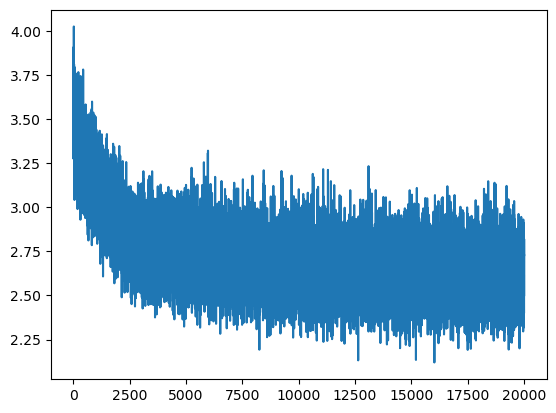

In [39]:
plt.plot(range(test_model.iterations),test_model.losses)

In [ ]:
#Okay now lets be professional and do this with PyTorch - like API
# The idea is that every layer or class defined below can be "called" on the input x
# And the params are sotred (and returned) using the layer.parameters() call 
# Even if we have no params, as in an activation function, the class will return an empty list
# This is actually quite cool

class Linear:
    
    def __init__(self, dim_in, dim_out, bias = True):
        self.bias = bias
        self.weight = torch.randn((dim_in,dim_out)) * 1/dim_in **2 # This is the kaiming normalization
        self.bias = torch.randn(dim_out) if bias else None

    def __call__(self,x):
        self.out =  (x@ self.weight + (self.bias if self.bias else 0))
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias else [])


class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps # Don't know what this is
        self.momentum = momentum # Do know what it is
        
        # Squeeze Factors (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)

        # Training Time Tools
        self.training = True 

        # Accumulators:s
        self.global_mean = torch.zeros(dim)
        self.global_var = torch.ones(dim) 

    def __call__(self,x):
        if self.training:
            xmean = x.mean(dim=0,keepdim = True)
            xvar = x.var(dim=0,keepdim = True)
        else:
            xmean = self.global_mean
            xvar = self.global_var

        # So we "whiten our batch"
        x_hat = (x - xmean)/ torch.sqrt(xvar + self.eps)

        # And create another scaling + shifting linear function
        self.out = self.gamma * x_hat + self.beta 

        # sprinkle in batch means and variance to capture population mean and var
        if self.training:
            with torch.no_grad():
                self.global_mean = (1- self.momentum) * self.global_mean + self.momentum * xmean
                self.global_var = (1 - self.momentum) * self.global_var + self.momentum * xvar
        
        return self.out


    def parameters(self):
        return [self.gamma, self.beta]
    

class Embedding:

    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn(num_embeddings,embedding_dim)
    
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:

    def __call__(self,x):
        self.out = x.view(x.shpae[0],-1)
        return self.out
    
    def parameters(self):
        return []


class ReLU:

    def __call__(self,x):
        self.out = torch.ReLU(x)
        return self.out

    def parameters(self):
        return []


class Tanh:

    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [70]:
#Lets define the net:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
bins = 27
context_len = 3 

C = torch.randn((bins, n_embd),            generator=g)
layers = [
  Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, bins, bias=False), BatchNorm1d(bins),
]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [71]:
### FROM KARPATHY:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958
